<a href="https://colab.research.google.com/github/fidanfatih/Fraud_Detection/blob/main/fraud_detection_phase11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Read dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# from category_encoders import CountEncoder
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.feature_selection import RFECV
import lightgbm as lgb
from tqdm import tqdm_notebook
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
import multiprocessing


import re
import gc
import warnings
warnings.filterwarnings('ignore')
warnings.warn("this will not show")

%matplotlib inline

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000
pd.options.display.max_colwidth = 1000

In [73]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Memory Reduction
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
%%time

files = ['/content/drive/MyDrive/Colab Notebooks/Fraud Detection/input/test_identity.csv.zip', 
         '/content/drive/MyDrive/Colab Notebooks/Fraud Detection/input/test_transaction.csv.zip',
         '/content/drive/MyDrive/Colab Notebooks/Fraud Detection/input/train_identity.csv.zip',
         '/content/drive/MyDrive/Colab Notebooks/Fraud Detection/input/train_transaction.csv.zip']

def load_data(file):
    return pd.read_csv(file)

with multiprocessing.Pool() as pool:
    test_id, test_tr, train_id, train_tr = pool.map(load_data, files)

CPU times: user 3.42 s, sys: 5.65 s, total: 9.08 s
Wall time: 57.7 s


In [5]:
train = pd.merge(train_tr, train_id, on='TransactionID', how='left')
test = pd.merge(test_tr, test_id, on='TransactionID', how='left')

del test_id, test_tr, train_id, train_tr
gc.collect()

15

In [6]:
# Check for column mismatches
def Diff(li1, li2):
    li1_dif = [i for i in li1 + li2 if i not in li1]
    li2_dif = [i for i in li1 + li2 if i not in li2]

    print(f"""not in list1:
{li1_dif}\n   
not in list2:
{li2_dif}""")

Diff(sorted(train.columns), sorted(test.columns))

not in list1:
['id-01', 'id-02', 'id-03', 'id-04', 'id-05', 'id-06', 'id-07', 'id-08', 'id-09', 'id-10', 'id-11', 'id-12', 'id-13', 'id-14', 'id-15', 'id-16', 'id-17', 'id-18', 'id-19', 'id-20', 'id-21', 'id-22', 'id-23', 'id-24', 'id-25', 'id-26', 'id-27', 'id-28', 'id-29', 'id-30', 'id-31', 'id-32', 'id-33', 'id-34', 'id-35', 'id-36', 'id-37', 'id-38']
   
not in list2:
['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'isFraud']


In [7]:
test.rename(columns=lambda x: x.replace("id-","id_") if "id-" in x else x, inplace=True)

In [8]:
one_value_cols = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]

many_null_cols = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.9]
many_null_cols_test = [col for col in test.columns if test[col].isnull().sum() / test.shape[0] > 0.9]

big_top_value_cols = [col for col in train.columns if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
big_top_value_cols_test = [col for col in test.columns if test[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]

cols_to_drop = list(set(many_null_cols + many_null_cols_test + big_top_value_cols + big_top_value_cols_test + one_value_cols + one_value_cols_test))
cols_to_drop.remove('isFraud')
print('{} features are going to be dropped for being useless'.format(len(cols_to_drop)))

train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

82 features are going to be dropped for being useless


In [9]:
test['isFraud'] = np.nan
df = pd.concat([train, test], ignore_index=True, sort=False)
del test, train

df = df.reset_index().drop('index', axis=1)
gc.collect()

63

In [10]:
df['Transaction_hour'] = np.floor(df['TransactionDT'] / 3600) % 24
df['Transaction_day_of_week'] = np.floor((df['TransactionDT'] / (3600 * 24) - 1) % 7)

In [11]:
df = reduce_mem_usage(df)

Mem. usage decreased to 1015.01 Mb (65.7% reduction)


In [12]:
# df.info(verbose=-1)

## FUNCTIONS

#### Description Functions

In [13]:
def null_values(df, rate=0):
    """a function to show null values with percentage"""
    nv=pd.concat([df.isnull().sum(), 100 * df.isnull().sum()/df.shape[0]],axis=1).rename(columns={0:'Missing_Records', 1:'Percentage (%)'})
    return nv[nv['Percentage (%)']>rate].sort_values('Percentage (%)', ascending=False)

#### Outlier Functions

In [14]:
def simplify_column(col, df=df, threshold=0.005, value='mode'):
  df[col] = df[col].replace(df[col].value_counts(dropna=True)[df[col].value_counts(dropna=True, normalize=True)<threshold].index,df[col].mode()[0] if value=='mode' else 'other')
  return df[col]

### Encoders

In [15]:
# Frequency Encoding

def frequency_encoder(cat_cols, df):
  for col in cat_cols:
    if col in df.columns:
      df= df.join(df[col].map(df[col].value_counts(normalize=True)).to_frame().add_suffix('_freq'))
  return df

### Modeling

In [16]:
def plot_feature_importances(model, num=10, figsize=(20,10)):
    feature_imp = pd.Series(model.feature_importances_,index=X.columns).sort_values(ascending=False)[:num]
    plt.figure(figsize=figsize)
    sns.barplot(x=feature_imp, y=feature_imp.index)
    plt.title("Feature Importance")
    plt.show()

## Exploratory Data Analysis (EDA)

### id_30

In [17]:
df['id_30'].replace(regex={r'^Android.*': 'android', 
                        '^Mac.*': 'mac',
                        '^Windows.*': 'windows', 
                        '^iOS.*': 'ios',
                        '^Linux.*': 'linux'}, inplace=True)

df['id_30'].value_counts(dropna=False)

NaN        949007
windows     69777
ios         38502
mac         25634
android     11783
linux        2488
func           21
other          19
Name: id_30, dtype: int64

### id_31

In [18]:
df.id_31.replace(regex={r'samsung.*': 'samsung_browser',
                        '^Samsung.*': 'samsung_browser',
                        '.*safari.*': 'safari',
                        'opera.*': 'opera', 
                        '^ie.*': 'ie',
                        'firefox.*': 'firefox',
                        '^Mozilla.*':'firefox',
                        'edge.*': 'edge', 
                        '^chrome.*': 'chrome',
                        '^google.*': 'chrome',
                        'android.*': 'android',
                        'Generic.*': 'android',
                        'Android':"android", 
                        'firefox.*': 'firefox',
                        'edge.*': 'edge', 
                        'Microsoft.*':'ie'}, inplace=True)

df.id_31.value_counts(dropna=False, normalize=True)


NaN                7.476311e-01
chrome             1.436780e-01
safari             6.367483e-02
ie                 1.424313e-02
firefox            1.311757e-02
edge               1.092295e-02
samsung_browser    4.362801e-03
android            1.083637e-03
opera              7.682977e-04
other              3.098709e-04
facebook           1.121004e-04
silk               1.731632e-05
mobile             1.640493e-05
ZTE/Blade          8.202466e-06
uc                 7.291081e-06
line               5.468311e-06
maxthon            5.468311e-06
comodo             5.468311e-06
aol                4.556926e-06
icedragon          4.556926e-06
palemoon           3.645540e-06
Lanix/Ilium        2.734155e-06
puffin             1.822770e-06
waterfox           1.822770e-06
iron               9.113851e-07
Nokia/Lumia        9.113851e-07
LG/K-200           9.113851e-07
Cherry             9.113851e-07
Inco/Minion        9.113851e-07
M4Tel/M4           9.113851e-07
rim                9.113851e-07
blackber

### id_33

In [19]:
df['id_33_1'] = df.id_33.fillna(value='0x0').str.extract('(\d*)x(\d*)').apply(lambda x: int(x[0])*int(x[1]), axis=1)
df['id_33_1'] = df['id_33_1'].replace({0:np.nan})
df['id_33_2'] = df['id_33'].str.split('x', expand=True)[0] 
df['id_33_3'] = df['id_33'].str.split('x', expand=True)[1] 
df.drop('id_33', axis=1, inplace=True)

### DeviceInfo

In [20]:
df.DeviceInfo.replace(regex={r'.*SAMSUNG.*': 'samsung',
                        '.*SM.*': 'samsung',
                        '^SC.*': 'samsung',
                        '.*Lenovo.*': 'lenovo',
                        '^V.*': 'lg',
                        '.*LG.*': 'lg',
                        '.*HUAWEI.*':'huawei',
                        '.*Huawei.*':'huawei',
                        '.*Moto.*':'motorola',
                        '.*moto.*':'motorola',
                        '.*HTC.*':'htc',
                        '.*Redmi.*':'redmi',
                        '.*Blade.*':'blade',
                        '.*BLADE.*':'blade',    
                        '.*Nexus.*':'nexus',
                        '.*GT.*':'gt',
                        '.*Pixel.*':'pixel',
                        '.*Hisense.*':'hisense',
                        '.*ALCATEL.*':'alcatel',
                        '.*ASUS.*':'asus',
                        '.*Ilium.*':'ilium',
                        '.*iris.*':'iris',
                        '.*Aquaris.*':'aquaris',
                        '.*Archos.*':'archos',
                        '.*Linux.*':'linux',
                        '.*Android.*':'android',
                        '.*Microsoft.*':'microsoft',
                        '.*MacOS.*':'macOS',
                        '.*Trident.*':'trident',
                        '.*rv.*':'rv',
                        '.*XT.*':'xt',
                        '.*Windows.*':'windows',
                        '.*TA.*':'ta',
                        '.*iOS.*':'ios',
                        '.*verykool.*':'verykool',
                        '.*0PM92.*':'htc',
                        '.*2PS64.*':'htc',
                        '.*HONOR.*':'honor',
                        '.*EGO.*':'other',
                         '^50.*':'alcatel',
                         '^60.*':'alcatel',
                         '^80.*':'alcatel',
                         '^A.*':'alcatel',
                         '^[CEFG].*':'sony',
                         '^SG.*':'sony',
                         '^M4.*':'m4',
                         '.*MOT.*':'morotola',
                         '^Mi.*':'xiaomi',
                         '^MI.*':'xiaomi',
                         '^Z.*':'zte',
                         '^K.*':'android'}, inplace=True)

df['DeviceInfo'] = simplify_column('DeviceInfo', df=df, threshold=0.0004, value='other')
df.DeviceInfo.value_counts(dropna=False, normalize=True)

NaN                       0.786988
windows                   0.084543
ios                       0.035090
samsung                   0.022849
macOS                     0.021620
trident                   0.011237
motorola                  0.007432
rv                        0.006559
lg                        0.004789
huawei                    0.004421
other                     0.002763
sony                      0.002072
alcatel                   0.001667
blade                     0.001031
xt                        0.000894
android                   0.000700
htc                       0.000602
hisense                   0.000538
pixel                     0.000530
lenovo                    0.000499
redmi                     0.000444
ilium                     0.000430
ta                        0.000321
m4                        0.000284
gt                        0.000284
linux                     0.000277
zte                       0.000246
hi6210sft Build/MRA58K    0.000175
xiaomi              

### R_emaildomain

In [21]:
df[['R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']] = df['R_emaildomain'].str.split('.', expand=True)

In [22]:
df = df.drop('R_emaildomain', axis=1)

### P_emaildomain

In [23]:
df[['P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3']] = df['P_emaildomain'].str.split('.', expand=True)

In [24]:
df = df.drop('P_emaildomain', axis=1)

### TransactionDT & TransactionID

In [25]:
df = df.drop('TransactionDT',axis=1)

In [26]:
df = df.drop('TransactionID',axis=1)

### Missing Values

In [27]:
nominal_cat= ['ProductCD', 'DeviceInfo', 'DeviceType'] + \
             ['R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3'] + \
             ['P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3']+ \
             ['id_12','id_15','id_16','id_23','id_27','id_28','id_29','id_30','id_31','id_33_1','id_33_2','id_33_3','id_34','id_35', 'id_36', 'id_37', 'id_38'] + \
             ['M1','M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']+ \
             ['card4', 'card6'] 
nominal_cat= [col for col in nominal_cat if col in df.columns]

ordinal_cat= [col for col in df.columns if (re.search('^id\d*', col)) and (df[col].nunique()<200)] + \
             [col for col in df.columns if (re.search('^M\d*', col)) and (df[col].nunique()<1000)] + \
             [col for col in df.columns if (re.search('^C\d*', col)) and (df[col].nunique()<1000)] + \
             [col for col in df.columns if (re.search('^card\d*', col)) and (df[col].nunique()<1000)] + \
             ['Transaction_day_of_week','Transaction_hour'] 

ordinal_cat = sorted( set(ordinal_cat) - set(nominal_cat) ) 
ordinal_cat = [col for col in ordinal_cat if col in df.columns]
print(ordinal_cat)

['C5', 'C9', 'Transaction_day_of_week', 'Transaction_hour', 'card2', 'card3', 'card5', 'id_01', 'id_03', 'id_04', 'id_05', 'id_06', 'id_09', 'id_10', 'id_11', 'id_13', 'id_14', 'id_17', 'id_32']


In [28]:
continous_col= sorted(set(df.columns) - set(ordinal_cat + nominal_cat))
continous_col.remove('isFraud') 
print(continous_col)

['C1', 'C10', 'C11', 'C12', 'C13', 'C14', 'C2', 'C4', 'C6', 'C7', 'C8', 'D1', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'D2', 'D3', 'D4', 'D5', 'D6', 'D8', 'D9', 'TransactionAmt', 'V1', 'V10', 'V100', 'V11', 'V12', 'V126', 'V127', 'V128', 'V13', 'V130', 'V131', 'V138', 'V139', 'V140', 'V141', 'V142', 'V143', 'V144', 'V145', 'V146', 'V147', 'V148', 'V149', 'V15', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155', 'V156', 'V157', 'V158', 'V159', 'V16', 'V160', 'V161', 'V162', 'V163', 'V164', 'V165', 'V166', 'V167', 'V168', 'V169', 'V17', 'V170', 'V171', 'V172', 'V173', 'V174', 'V175', 'V176', 'V177', 'V178', 'V179', 'V18', 'V180', 'V181', 'V182', 'V183', 'V184', 'V185', 'V186', 'V187', 'V188', 'V189', 'V19', 'V190', 'V191', 'V192', 'V193', 'V194', 'V195', 'V196', 'V197', 'V198', 'V199', 'V2', 'V20', 'V200', 'V201', 'V202', 'V203', 'V204', 'V205', 'V206', 'V207', 'V208', 'V209', 'V21', 'V210', 'V211', 'V212', 'V213', 'V214', 'V215', 'V216', 'V217', 'V218', 'V219', 'V22', 'V220', 'V221', 'V22

In [29]:
df[continous_col] = df[continous_col].replace([np.inf, -np.inf], np.nan)

In [30]:
V_columns = [col for col in df.columns if re.search('^V\d*', col)]
df[V_columns] = df[V_columns].fillna(-1)

df[nominal_cat] = df[nominal_cat].fillna('None')
df[ordinal_cat] = df[ordinal_cat].fillna(-999)
df[continous_col] = df[continous_col].fillna(df[continous_col].median())

### Frequency Encoders

In [31]:
df = frequency_encoder(nominal_cat, df)
df = df.drop(nominal_cat, axis=1)

In [32]:
df['TransactionAmt_to_mean_card1'] = df['TransactionAmt'] / df.groupby(['card1'])['TransactionAmt'].transform('mean')
df['TransactionAmt_to_mean_card4'] = df['TransactionAmt'] / df.groupby(['card4_freq'])['TransactionAmt'].transform('mean')
df['TransactionAmt_to_std_card1'] = df['TransactionAmt'] / df.groupby(['card1'])['TransactionAmt'].transform('std')
df['TransactionAmt_to_std_card4'] = df['TransactionAmt'] / df.groupby(['card4_freq'])['TransactionAmt'].transform('std')

df['id_02_to_mean_card1'] = df['id_02'] / df.groupby(['card1'])['id_02'].transform('mean')
df['id_02_to_mean_card4'] = df['id_02'] / df.groupby(['card4_freq'])['id_02'].transform('mean')
df['id_02_to_std_card1'] = df['id_02'] / df.groupby(['card1'])['id_02'].transform('std')
df['id_02_to_std_card4'] = df['id_02'] / df.groupby(['card4_freq'])['id_02'].transform('std')

df['D15_to_mean_card1'] = df['D15'] / df.groupby(['card1'])['D15'].transform('mean')
df['D15_to_mean_card4'] = df['D15'] / df.groupby(['card4_freq'])['D15'].transform('mean')
df['D15_to_std_card1'] = df['D15'] / df.groupby(['card1'])['D15'].transform('std')
df['D15_to_std_card4'] = df['D15'] / df.groupby(['card4_freq'])['D15'].transform('std')

df['D15_to_mean_addr1'] = df['D15'] / df.groupby(['addr1'])['D15'].transform('mean')
df['D15_to_std_addr1'] = df['D15'] / df.groupby(['addr1'])['D15'].transform('std')

# Decimal part of the transaction amount.
df['TransactionAmt_decimal'] = ((df['TransactionAmt'] - df['TransactionAmt'].astype(int)) * 1000).astype(int)

cols = list(df.columns)
cols.remove('isFraud')
df[cols] = df[cols].fillna(df[cols].median())

In [33]:
train = df[df['isFraud'].notna()].reset_index().drop('index', axis=1)
test = df[df['isFraud'].isna()].reset_index().drop('index', axis=1)
del df

### PCA for V Columns

In [34]:
V_columns = [col for col in train.columns if re.search('^V\d*', col)]

sc_V = MinMaxScaler()
sc_V.fit(train[V_columns])
train[V_columns] = sc_V.transform(train[V_columns])
test[V_columns] = sc_V.transform(test[V_columns])

In [35]:
pca = PCA(n_components = 21)
pca.fit(train[V_columns])
pca_V_train = pca.transform(train[V_columns])
pca_V_test = pca.transform(test[V_columns])

np.cumsum(pca.explained_variance_ratio_)

array([0.47443765, 0.69761739, 0.76618732, 0.81915159, 0.85423244,
       0.88495586, 0.90853473, 0.92419495, 0.932511  , 0.93823319,
       0.94335308, 0.94744803, 0.95119948, 0.95454271, 0.95737427,
       0.95995375, 0.96232531, 0.96452959, 0.96668951, 0.9685924 ,
       0.97043501])

In [36]:
gc.collect()

112

In [37]:
pca_V_train = pd.DataFrame(data = pca_V_train).add_prefix('pca_V')
train = pd.concat([train, pca_V_train], ignore_index=False, sort=False, axis=1)
train.drop(V_columns, axis=1, inplace=True)

pca_V_test = pd.DataFrame(data = pca_V_test).add_prefix('pca_V')
test = pd.concat([test, pca_V_test], ignore_index=False, sort=False, axis=1)
test.drop(V_columns, axis=1, inplace=True)


In [38]:
del pca_V_train, pca_V_test

### PCA for id Columns

In [39]:
id_columns=[col for col in train.columns if re.search('^id_\d\d$', col)]
id_columns.remove("id_20")
id_columns.remove("id_02")

sc_id = MinMaxScaler()
sc_id.fit(train[id_columns])
train[id_columns] = sc_id.transform(train[id_columns])
test[id_columns] = sc_id.transform(test[id_columns])

In [40]:
pca = PCA(n_components = 4)
pca.fit(train[id_columns])
pca_id_train = pca.transform(train[id_columns])
pca_id_test = pca.transform(test[id_columns])

np.cumsum(pca.explained_variance_ratio_)

array([0.80152192, 0.91721408, 0.96029468, 0.97580567])

In [41]:
pca_id_train = pd.DataFrame(data = pca_id_train).add_prefix('pca_id')
train = pd.concat([train, pca_id_train], ignore_index=False, sort=False, axis=1)
train.drop(id_columns, axis=1, inplace=True)

pca_id_test = pd.DataFrame(data = pca_id_test).add_prefix('pca_id')
test = pd.concat([test, pca_id_test], ignore_index=False, sort=False, axis=1)
test.drop(id_columns, axis=1, inplace=True)

In [42]:
del pca_id_train, pca_id_test

In [43]:
gc.collect()

100

### PCA for C Columns

In [44]:
C_columns = [col for col in train.columns if re.search('^C\d*', col)]

sc_C = MinMaxScaler()
sc_C.fit(train[C_columns])
train[C_columns] = sc_C.transform(train[C_columns])
test[C_columns] = sc_C.transform(test[C_columns])

In [45]:
pca = PCA(n_components = 2)
pca.fit(train[C_columns])
pca_C_train = pca.transform(train[C_columns])
pca_C_test = pca.transform(test[C_columns])

np.cumsum(pca.explained_variance_ratio_)

array([0.60192569, 0.96560961])

In [46]:
gc.collect()

50

In [47]:
pca_C_train = pd.DataFrame(data = pca_C_train).add_prefix('pca_C')
train = pd.concat([train, pca_C_train], ignore_index=False, sort=False, axis=1)
train.drop(C_columns, axis=1, inplace=True)

pca_C_test = pd.DataFrame(data = pca_C_test).add_prefix('pca_C')
test = pd.concat([test, pca_C_test], ignore_index=False, sort=False, axis=1)
test.drop(C_columns, axis=1, inplace=True)


### Export Data

In [48]:
test = test.drop('isFraud', axis=1)

In [74]:
# train.to_pickle('/content/drive/MyDrive/Colab Notebooks/Fraud Detection/train_last.pkl')
# test.to_pickle('/content/drive/MyDrive/Colab Notebooks/Fraud Detection/test_last.pkl')
train= pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/Fraud Detection/input/train_last.pkl')
# test= pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/Fraud Detection/input/test_last.pkl')
gc.collect()

17580

In [75]:
df = train.copy()
del train
# del test

df = reduce_mem_usage(df)

Mem. usage decreased to 131.78 Mb (40.9% reduction)


## Modeling with LightGBM

In [76]:
import pandas as pd
import numpy as np
import multiprocessing
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from time import time
import datetime
from tqdm import tqdm_notebook
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.metrics import roc_auc_score

# for modeling 
import sklearn
from lightgbm import LGBMClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, train_test_split, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report, recall_score, f1_score
from sklearn.metrics import plot_precision_recall_curve, precision_recall_curve, plot_roc_curve, roc_curve, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import datasets, metrics
from sklearn.decomposition import PCA

# to avoid warnings
import warnings
warnings.filterwarnings('ignore')
warnings.warn("this will not show")



warnings.simplefilter('ignore')
sns.set()
%matplotlib inline

In [77]:
X = df.drop(['isFraud'], axis=1)
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state =101)

In [78]:
# LGBMClassifier with GPU

clf = LGBMClassifier(
          num_leaves = 256,
          min_child_samples = 79,
          objective = 'binary',
          max_depth = 13,
          learning_rate = 0.03,
          boosting_type = "gbdt",
          subsample_freq = 3,
          subsample = 0.9,
          bagging_seed = 11,
          metric = 'auc',
          verbosity = -1,
          reg_alpha = 0.3,
          reg_lambda = 0.3,
          colsample_bytree = 0.9,
          is_unbalance = True,
)

In [79]:
%time 
clf.fit(X_train, y_train)
# %time prints CPU Times and Wall Time

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10.5 µs


LGBMClassifier(bagging_seed=11, boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.9, importance_type='split', is_unbalance=True,
               learning_rate=0.03, max_depth=13, metric='auc',
               min_child_samples=79, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=256, objective='binary',
               random_state=None, reg_alpha=0.3, reg_lambda=0.3, silent=True,
               subsample=0.9, subsample_for_bin=200000, subsample_freq=3,
               verbosity=-1)

In [80]:
gc.collect()

256

### Feature Importance

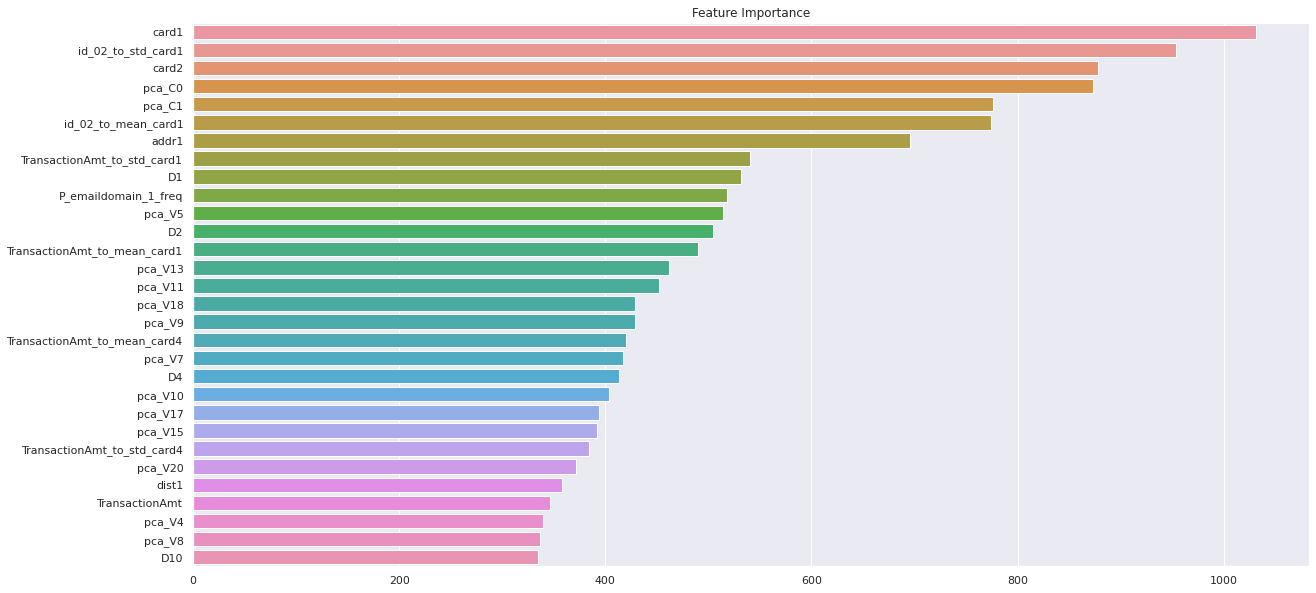

In [81]:
plot_feature_importances(clf, 30)

### Model Evaluation

In [82]:
y_pred = clf.predict(X_test)

              precision    recall  f1-score   support

         0.0       0.99      0.92      0.96    142469
         1.0       0.27      0.80      0.40      5166

    accuracy                           0.92    147635
   macro avg       0.63      0.86      0.68    147635
weighted avg       0.97      0.92      0.94    147635



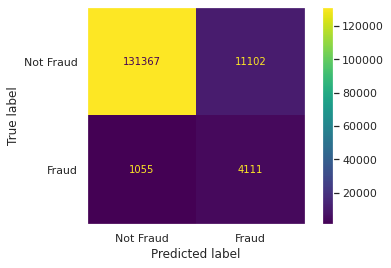

In [83]:
plot_confusion_matrix(clf, X_test, y_test, values_format = '', 
                      display_labels=['Not Fraud', 'Fraud'])
plt.grid(None)
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

         0.0       1.00      0.93      0.96    427408
         1.0       0.31      0.91      0.46     15497

    accuracy                           0.92    442905
   macro avg       0.65      0.92      0.71    442905
weighted avg       0.97      0.92      0.94    442905



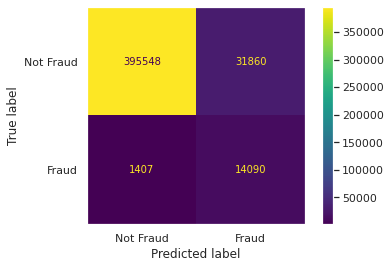

In [84]:
y_train_pred = clf.predict(X_train)
plot_confusion_matrix(clf, X_train, y_train, values_format = '', 
                      display_labels=['Not Fraud', 'Fraud'])
plt.grid(None)
print(classification_report(y_train, y_train_pred, zero_division=0))

In [85]:
print('Test ROC AUC score:', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
print('Train ROC AUC score:', roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))

Test ROC AUC score: 0.9378933653522529
Train ROC AUC score: 0.9766556666766617


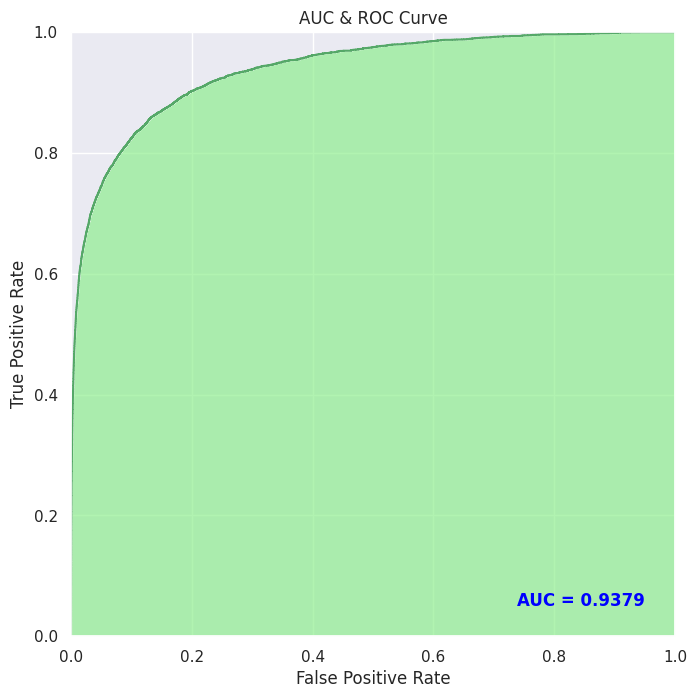

In [86]:
from sklearn import metrics

clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)[:, 1]

auc = metrics.roc_auc_score(y_test, y_pred)

false_positive_rate, true_positive_rate, thresolds = metrics.roc_curve(y_test, y_pred)

plt.figure(figsize=(8, 8), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

### Training with all train data

In [129]:
X = df.drop(['isFraud'], axis=1)
y = df['isFraud']

In [130]:
# LGBMClassifier with GPU

clf = LGBMClassifier(
          num_leaves = 256,
          min_child_samples = 79,
          objective = 'binary',
          max_depth = 13,
          learning_rate = 0.03,
          boosting_type = "gbdt",
          subsample_freq = 3,
          subsample = 0.9,
          bagging_seed = 11,
          metric = 'auc',
          verbosity = -1,
          reg_alpha = 0.3,
          reg_lambda = 0.3,
          colsample_bytree = 0.9,
          is_unbalance = True,
)

In [131]:
%time 
clf.fit(X, y)
# %time prints CPU Times and Wall Time

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.82 µs


LGBMClassifier(bagging_seed=11, boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.9, importance_type='split', is_unbalance=True,
               learning_rate=0.03, max_depth=13, metric='auc',
               min_child_samples=79, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=256, objective='binary',
               random_state=None, reg_alpha=0.3, reg_lambda=0.3, silent=True,
               subsample=0.9, subsample_for_bin=200000, subsample_freq=3,
               verbosity=-1)

In [142]:
gc.collect()

813

### Predict test data

In [88]:
test= pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/Fraud Detection/input/test_last.pkl')

In [90]:
sub= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Fraud Detection/input/sample_submission.csv.zip')

In [133]:
sub['isFraud']=pd.DataFrame(clf.predict_proba(test))[[1]]

In [134]:
sub.to_csv('/content/drive/MyDrive/Colab Notebooks/Fraud Detection/submission.csv',index=False)

In [143]:
sub

,TransactionID,isFraud
0,3663549,0.046354
1,3663550,0.139229
2,3663551,0.155210
3,3663552,0.074451
4,3663553,0.084334
...,...,...
506686,4170235,0.238379
506687,4170236,0.282795
506688,4170237,0.144010
506689,4170238,0.128291
